In [20]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
from matplotlib import colors
from metpy.plots.ctables import registry
from metpy.plots import USCOUNTIES
from metpy.units import units
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
import xarray as xr

In [21]:
%%capture
# Scan the catalog and download the data
def get_satellite():
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                        'TotalPrecipitableWater/FullDisk/current/catalog.xml')
    dataset = satcat.datasets[0]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

ds = get_satellite()

In [22]:
# Parse out data from satellite file
data = ds.metpy.parse_cf('TPW')
proj = data.metpy.cartopy_crs
x = data['x']
y = data['y']

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time


VALID_TIME = convert_datetime(str(data['t'].values).split('.')[0])

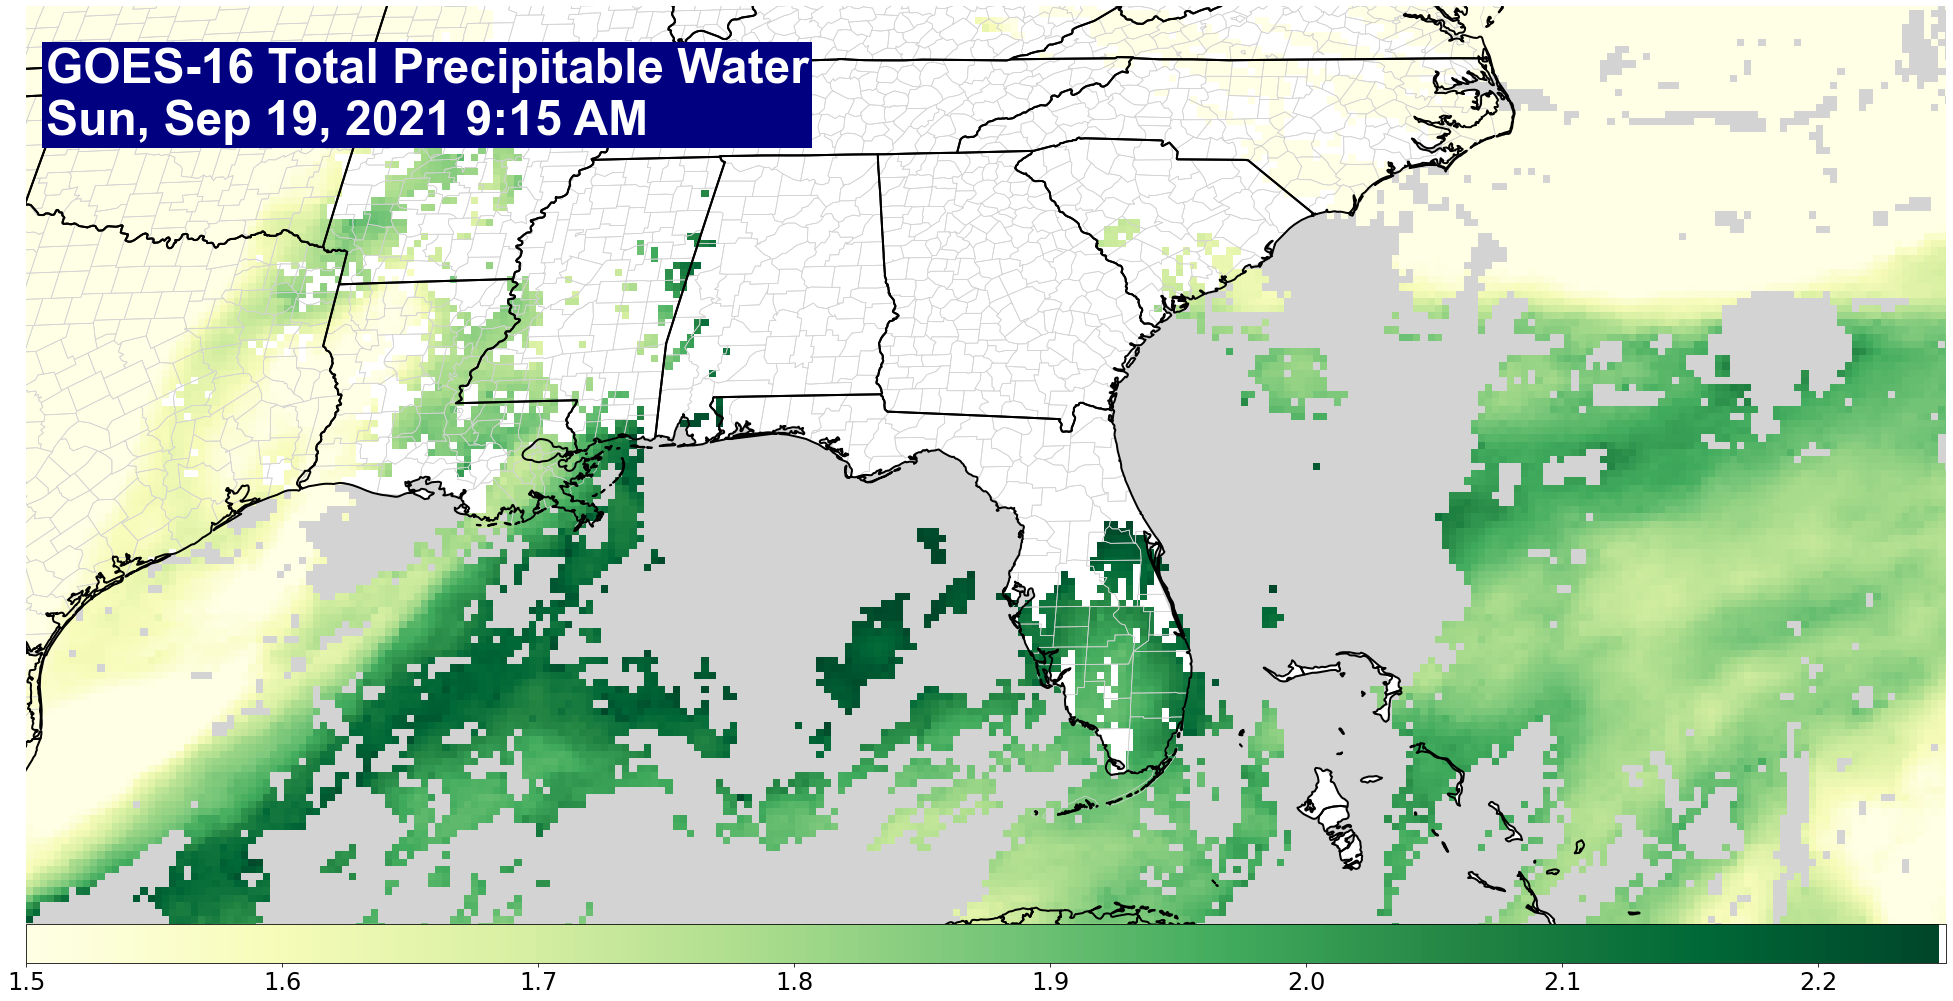

In [23]:
# Build the plot
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=proj)

ax.set_extent([-96.1, -70, 23.2, 37.5])

cmap = plt.cm.YlGn

# extract all colors from the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# Make the last color entry to be alpha
cmaplist[-1] = (1, 1, 1, 0)
# create the new colormap
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.spines['geo'].set_visible(False)

im = ax.imshow(data / 25.4, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='upper', vmin=1.50, vmax=2.25, cmap=cmap)

cbar = plt.colorbar(im, orientation='horizontal', pad=0, aspect=50)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'GOES-16 Total Precipitable Water\n{VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
plt.savefig(f'{graphics_dir}/pwat.png', dpi=72)
plt.show()